# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных будет аналитическая записка, в которой опишу:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Цели и задачи проекта

Выгрузить данные и провести предобработку данных(проверку на дубликаты),сравним размеры групп, их статистики и распределение.

Так же предстоит проверить гипотезу: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

По результатам анализа подготовить аналитическую записку,в которой будет описаны результаты тестов,их значения а так-же обьяснить как мы пришли к этим выводам и результатам.
</font>

## Описание данных

Работать будем с таблицей:

- `тут_была_ссылка` — таблица с идентификаторами пользователей из городов Москва и Санкт-Петербург,а так же их общее количество часов активности. Путь к файлу: `тут_была_ссылка`.

Поля таблицы:

- `city` — Город(Москва или Санкт-Петербург);

- `puid` — идентификатор пользователя;

- `hours` — общее количество часов активности;

</font>

## Содержимое проекта

Наша задача: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.</font>

---

## 1. Загрузка данных,знакомство с ними и их предварительная подготовка

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `тут_была_ссылка`.

####  Импорт необходимых библиотек,загрузка данных и знакомство с ними

- Импортируем необходимые библиотеки.

- Считаем и сохраним в датафрейм `df` CSV-файл `тут_была_ссылка`.

*Выведем на экран первые пять строк полученного датафрейма.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('тут_была_ссылка')

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

In [4]:
display(df.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


#### Удаляем лишний столбец

In [5]:
df = df.drop(columns = ['Unnamed: 0'])

display(df.head())

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


#### Поиск дублей и пропусков

In [6]:
df_null = df.isnull().sum().sum()
df_dp = df.duplicated().sum()
unic_id = df['puid'].nunique()

print(f'Полных дупликатов {df_dp},пропусков {df_null}, уникальных пользователей: {unic_id}')

Полных дупликатов 0,пропусков 0, уникальных пользователей: 8540


In [7]:
unique_id_1 = df.duplicated(subset = ['puid']).sum()

print(f'Количество неявных дубликатов {unique_id_1}')

Количество неявных дубликатов 244


In [8]:
df = df.drop_duplicates(subset = ['puid'], keep = 'first') 
print(f'Количество строк в очищенном датафрейме: {len(df)}')

Количество строк в очищенном датафрейме: 8540


## Исследовательский анализ данных (EDA)

Исследовательский анализ данных — неотъемлемая часть работы аналитика.Она помогает лучше понять закономерности в данных.

In [9]:
df_user_count = df['city'].value_counts()

print(df_user_count)

Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64


*Распределение показывает что в Москве почти в 3 раза больше пользователей.Далее посчитаем статистические показатели.*

#### Подсчёт статистических показателей

In [10]:
stats = df.groupby('city')['hours'].agg(
        count='count',
        mean='mean',
        max='max',
        min='min',
        median='median',
        std='std')

display(stats)

,count,mean,max,min,median,std
city,,,,,,
Москва,6234,10.881092,857.209373,0.000018,0.924498,36.851683
Санкт-Петербург,2306,11.264433,978.764775,0.000025,0.875355,39.831755


*Видим разницу между медианой и средним,что говорит о наличии выбросов.*

*Проверим это.*

#### Строим гистограмму распределния

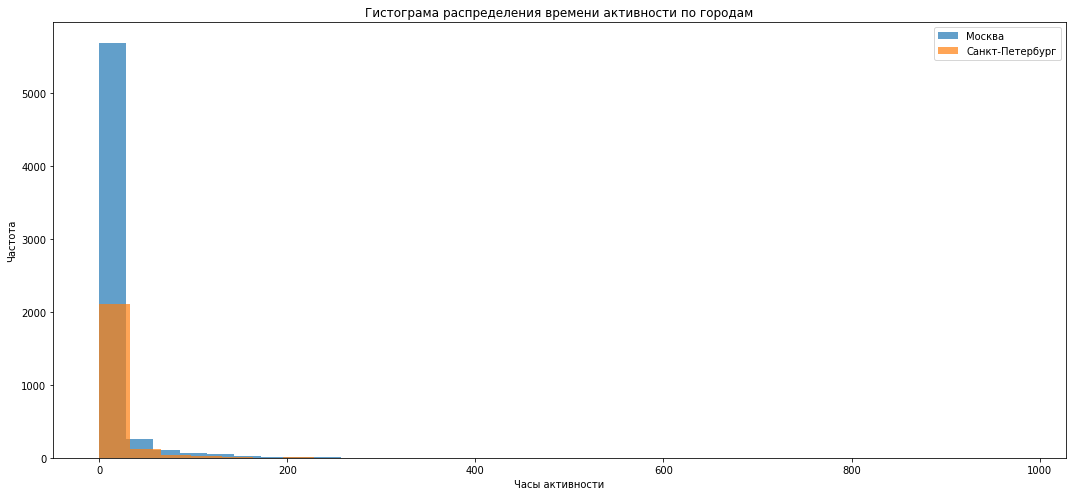

In [11]:
moscow_df = df[df['city'] == 'Москва']['hours']
spb_df = df[df['city'] == 'Санкт-Петербург']['hours']

plt.figure(figsize=(15,7))
plt.hist(moscow_df, bins = 30, alpha = 0.7, label = 'Москва')
plt.hist(spb_df, bins = 30, alpha = 0.7, label = 'Санкт-Петербург')
plt.title('Гистограма распределения времени активности по городам')
plt.xlabel('Часы активности')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

*На гистограмме видно что имеется хвост,что говорит о том что для проверки гипотезы луше подойдёт t-тест Манна-Уитни.*

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [12]:
moscow_t = df.loc[df['city'] == 'Москва', 'hours']
spb_t = df.loc[df['city'] == 'Санкт-Петербург', 'hours']

gep_ms, p_value = mannwhitneyu(spb_t, moscow_t, alternative = 'greater')

alpha = 0.05

print(f'p_value сотсавило {p_value}')

if p_value < alpha:
      print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
else:
      print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')

p_value сотсавило 0.6189600878052618
Полученное значение p_value=0.6189600878052618 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



**Проведен тест Манна-Уитни потому что он не требует нормальности выборок или равенства дисперсий, а также устойчив к выбросам. Установили уровень значимости а=0.05 как норму для продуктовых гипотез.**


**На основании полученного p-value (0,619 > 0,05 (уровень значимости)), нет оснований отклонять нулевую гипотезу.Что говорит о том что различий во времени активности между двумя городами отсутствует.**


**Такие результаты могут быть связаны с тем, что:**
- **города похожи, возможно поэтому пользователи из обоих городов используют приложение с похожей частотой**
- **возможно нехватка объёма выборки**
- **возможно, есть и другие приложения, которые пользуются большей популярностью**

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Целью исследования является оценка эффективности нового интерфейса интернет-магазина BitMotion Kit, протестированного в формате A/B-теста.

Гипотеза теста: упрощение интерфейса повысит конверсию зарегистрированных пользователей в покупку как минимум на 3 процентных пункта в течение первых 7 дней после регистрации.


## 2. Загрузите данные, оцените их целостность.


In [13]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [14]:
display(participants.head())
display(participants.info())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

In [15]:
display(events.head())
display(events.info())

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

*Проведём проверку данных на пропуски и дубликаты:*

In [16]:
print(participants.isnull().sum())

user_id    0
group      0
ab_test    0
device     0
dtype: int64


In [17]:
print(events.isnull().sum())

user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


In [18]:
duplicates_part = participants.duplicated().sum()

print(f'Количество дубликатов в participants: {duplicates_part}')

duplicates_events = events.duplicated().sum()

print(f'Количество дубликатов в events: {duplicates_events}')

Количество дубликатов в participants: 0
Количество дубликатов в events: 36318


In [19]:
events = events.drop_duplicates()
duplicates_events_1 = events.duplicated().sum()

print(f'Количество дубликатов в events: {duplicates_events_1}')

Количество дубликатов в events: 0


Таблица participants имеет 4 столбца и 14 525 строк. Все столбцы типа object. Пропусков и полных дубликатов нет.

Таблица event имеет 4 столбца и 787 286 строк. Все столбцы типа object, кроме event_dt - он типа datetime. Пропуски есть только в столбце details и составляют подавляющее большинство (538 264), также есть дубликаты - 36 318 значений. Дубликаты удалены.


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

*Проверим наличие пользователей, которые участвуют одновременно в разных тестах (группах А и В). Если такие пересечения обнаружатся — исключим этих пользователей из анализа. Это необходимо, поскольку неизвестно, какие именно вмешательства проводятся в параллельном тесте и как их эффекты могут повлиять на результаты нашего эксперимента.*

In [20]:
group_a = participants[participants['group'] == 'A']
a_multi_tests = group_a.groupby('user_id')['ab_test'].nunique()
a_problem_users = a_multi_tests[a_multi_tests > 1].index

print(f'Количество пользователей в группе A более чем в одном тесте: {len(a_problem_users)}')

participants_clean = participants[~participants['user_id'].isin(a_problem_users)]

print(f'Размер выборки после удаления проблемных пользователей из группы A: {participants_clean.shape[0]}')

group_b = participants_clean[participants_clean['group'] == 'B']
b_multi_tests = group_b.groupby('user_id')['ab_test'].nunique()
b_problem_users = b_multi_tests[b_multi_tests > 1].index

print(f'Количество пользователей в группе B более чем в одном тесте: {len(b_problem_users)}')

participants_final_clean = participants_clean[~participants_clean['user_id'].isin(b_problem_users)]

print(f'Итоговый размер выборки после удаления всех проблемных пользователей: {participants_final_clean.shape[0]}')

Количество пользователей в группе A более чем в одном тесте: 325
Размер выборки после удаления проблемных пользователей из группы A: 13875
Количество пользователей в группе B более чем в одном тесте: 116
Итоговый размер выборки после удаления всех проблемных пользователей: 13643


*Проверим пересечение между двумя тестами. Удалим пересечения из нужного там теста и будем проводить проверку с чистым датафреймом*

In [21]:
int_test = participants.query('ab_test == "interface_eu_test"')
rec_test = participants.query('ab_test == "recommender_system_test"')
tests_intersection = list(set(int_test.user_id) & set(rec_test.user_id))

print(f'Количество пользователей, которые встречаются одновременно в двух конкурирующих тестах: {len(tests_intersection)}')

Количество пользователей, которые встречаются одновременно в двух конкурирующих тестах: 887


In [22]:
int_test_clean = int_test[~int_test.user_id.isin(tests_intersection)]

print(f'Исходный размер int_test: {len(int_test)}')
print(f'Очищенный размер int_test: {len(int_test_clean)}')
print(f'Удалено пользователей: {len(int_test) - len(int_test_clean)}')

tests_intersection_2 = set(int_test_clean.user_id) & set(rec_test.user_id)

print(f'Оставшееся пересечение после очистки: {len(tests_intersection_2)}')

Исходный размер int_test: 10850
Очищенный размер int_test: 9963
Удалено пользователей: 887
Оставшееся пересечение после очистки: 0


*Оставим нужный тест и проверим наличие групп:*

In [23]:
participants_eu = int_test_clean

print(participants_eu['group'].unique())

['B' 'A']


*Проверим на дубликаты:*

In [24]:
duplicates_eu = participants_eu['user_id'].duplicated().sum()

print(f'Количество дубликатов в participants_eu:{duplicates_eu}')

Количество дубликатов в participants_eu:0


*Проверим распределение по группам:*

In [25]:
group_a = participants_eu[participants_eu['group'] == 'A']['user_id'].unique().shape[0]
group_b = participants_eu[participants_eu['group'] == 'B']['user_id'].unique().shape[0]

print(f' Количество уникальных пользователей в группе А: {group_a}')
print(f' Количество уникальных пользователей в группе B: {group_b}')

group_counts = participants_eu['group'].value_counts(normalize=True)

print(group_counts)

 Количество уникальных пользователей в группе А: 4952
 Количество уникальных пользователей в группе B: 5011
B    0.502961
A    0.497039
Name: group, dtype: float64


*Распределение по численности выборок почти 50/50, что является хорошим показателем.*

*Проверим распределение по устройству, с которого проходила регистрация:*

In [26]:
group_a_device = participants_eu[participants_eu['group'] == 'A'].groupby('device')['user_id'].count()
group_b_device = participants_eu[participants_eu['group'] == 'B'].groupby('device')['user_id'].count()

print(group_a_device)
print(group_b_device)

device
Android    2264
Mac         515
PC         1223
iPhone      950
Name: user_id, dtype: int64
device
Android    2218
Mac         511
PC         1302
iPhone      980
Name: user_id, dtype: int64


*Распределение по устройствам также почти одинаковое, это хорошо.*

*Проверим пересечения в группах:*

In [27]:
int_group_a = set(participants_eu[participants_eu['group'] == 'A']['user_id'])
int_group_b = set(participants_eu[participants_eu['group'] == 'B']['user_id'])
intersect_users = int_group_a.intersection(int_group_b)

print(f'Количество пользователей, попавших одновременно в группы A и B: {len(intersect_users)}')

Количество пользователей, попавших одновременно в группы A и B: 0


*Промежуточный вывод:*

*Предыдущий аналитик хорошо подготовил данные перед проведением A/B теста*

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [28]:
interface_eu_users = participants_eu[participants_eu['ab_test'] == 'interface_eu_test']['user_id']
interface_eu_events = events[events['user_id'].isin(interface_eu_users)]
                                                                                        
print(f"Всего событий: {len(interface_eu_events)}")
print(interface_eu_events.head())

Всего событий: 68074
                user_id            event_dt    event_name details
64672  5F506CEBEDC05D30 2020-12-06 14:10:01  registration     0.0
64946  51278A006E918D97 2020-12-06 14:37:25  registration    -3.8
66585  A0C1E8EFAD874D8B 2020-12-06 17:20:22  registration   -3.32
67873  275A8D6254ACF530 2020-12-06 19:36:54  registration   -0.48
67930  0B704EB2DC7FCA4B 2020-12-06 19:42:20  registration     0.0


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

*Алгоритм работы будет следующим: Для каждого пользователя определим дату первого действия (момент регистрации). Затем присоединим эти данные к основному датафрейму. Рассчитаем разницу в днях между датой регистрации и датой каждого события, создав новый столбец. После этого отфильтруем только те события, которые произошли в течение первых 7 дней с момента регистрации, как того требует условие задачи.*

In [29]:
interface_eu_events_fixed = interface_eu_events.copy()
interface_eu_events_fixed['event_dt'] = pd.to_datetime(interface_eu_events_fixed['event_dt'])

registration = interface_eu_events_fixed[interface_eu_events_fixed['event_name'] == 'registration'].groupby('user_id')['event_dt'].min()
registration = registration.reset_index()
registration = registration.rename(columns={'event_dt': 'registration_dt'})
interface_eu_events_reg = interface_eu_events_fixed.merge(registration, on='user_id', how='left')
interface_eu_events_reg['days_since_registration'] = (interface_eu_events_reg['event_dt'] - interface_eu_events_reg['registration_dt']).dt.days
events_7_days = interface_eu_events_reg[
    (interface_eu_events_reg['days_since_registration'] >= 0) &
    (interface_eu_events_reg['days_since_registration'] <= 6)]
print(f"Событий в первые 7 дней после регистрации: {len(events_7_days)}")

Событий в первые 7 дней после регистрации: 58692


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

*Для расчета выборки воспользуемся калькулятором Эвана Миллера (https://www.evanmiller.org/abtesting/sample-size.html).*

*Достаточный размер группы по калькулятору: 3 692 пользователя.*
    
*В нашем тесте количество уникальных пользователей в группе А: 4952, в группе B: 5011.*

*Выборка достаточна для проведенного теста.*

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [30]:
purchases = events_7_days[(events_7_days['user_id'].isin(interface_eu_users)) & (events_7_days['event_name'] == 'purchase')]
purchases = purchases.merge(participants_eu[['user_id', 'group']], on='user_id', how='left')
buyers_per_group = purchases.groupby('group')['user_id'].nunique().reset_index(name='buyers')
total_per_group = participants_eu.groupby('group')['user_id'].nunique().reset_index(name='total_users')
summary = buyers_per_group.merge(total_per_group, on='group')
summary['conversion'] = (summary['buyers'] / summary['total_users']).round(3)

print(summary)

  group  buyers  total_users  conversion
0     A    1377         4952       0.278
1     B    1480         5011       0.295


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [31]:
conv_A = summary.loc[summary['group'] == 'A', 'conversion'].values[0]
conv_B = summary.loc[summary['group'] == 'B', 'conversion'].values[0]

conv_change = (conv_B - conv_A) * 100
conv_change_1 = (conv_B - conv_A)/ conv_A * 100

print(f"Рост конверси (абсолютное значение): {conv_change:.2f} п.п.")
print(f"Рост конверси (относительное значение): {conv_change_1:.2f}%")

Рост конверси (абсолютное значение): 1.70 п.п.
Рост конверси (относительное значение): 6.12%


*Промежуточный вывод:*

*Разница в конверсии между тестовой (B) и контрольной (A) группами составила 1.7 процентных пункта (29.5% против 27.8%). Хотя в тестовой группе наблюдается положительная динамика, величина эффекта не достигает целевого значения в 3 процентных пункта, заявленного в гипотезе. Для принятия обоснованного решения о результатах теста требуется оценка статистической значимости полученных различий.*

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

*Поскольку требуется проверить конверсию (долевой показатель) на независимых выборках, то используем Z-тест. Уровень значимости примем стандартным - 0.05.*

Примем гипотезы:

- Нулевая гипотеза H₀: Конверсия в группе B не выше, чем в группе A.
- Альтернативная гипотеза H₁: Конверсия в группе B выше, чем в группе A.


In [32]:
buy = summary.sort_values('group', ascending=False)['buyers'].values
all = summary.sort_values('group', ascending=False)['total_users'].values

stat_ztest, p_value_ztest = proportions_ztest(buy, all, alternative='larger')

print(f'p-value: {p_value_ztest:.3f}')

alpha = 0.05

if p_value_ztest < alpha:
    print('Отклоняем H0: Конверсия в группе B статистически значимо выше.')
else:
    print('Нет оснований отклонить H0: статистически значимых различий нет.')

p-value: 0.028
Отклоняем H0: Конверсия в группе B статистически значимо выше.


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

*Результаты A/B-теста показали, что конверсия в группе B составила 29.5%, в то время как в контрольной группе A - 27.8%. Разница между группами составляет +1.7 процентных пункта.*

*Статистический анализ с использованием Z-теста не выявил значимых различий между группами на заданном уровне значимости. Это означает, что наблюдаемое увеличение конверсии может быть случайным и не связано с внедрением нового интерфейса.*

*Целевой показатель не достигнут, прирост конверсии недостаточен с точки зрения статистики, однако динамика положительная.*

**Вывод: на данном этапе внедрение нового интерфейса нежелательно, условия ТЗ не выполнены. При необходимости все же достичь желаемых результатов рекомендуется провести еще один тест с большей выборкой, или длительностью, или еще провести изменения в интерфейсе сайта, чтобы достичь целевого показателя.**